# Football Manager 2024 - Player Valuation Analysis

An attempt to model player valuation based on their attributes to find undervalued attributes.

### Data Loading

In [46]:
import pandas as pd
import numpy as np
import datetime as dt


# Importing the dataset into a pandas dataframe
file = "data/Export 10K players.rtf"
df = pd.read_csv(file, delimiter="|")

### Data Pre-Processing

In [47]:
df = df.rename(columns=str.strip) #stripping column names
df.dropna(subset=["Height"], inplace=True)
df.drop(columns=['Unnamed: 0'], inplace=True)

# Strip spaces, and convert wage to a float
df["Wage"] = df["Wage"].str.strip()
df["Wage"] = df["Wage"].str.replace("£", "", regex=True)
df["Wage"] = df["Wage"].str.replace(",", "", regex=True)
df["Wage"] = df["Wage"].str.replace(" p/w", "", regex=True)
df["Wage"] = df["Wage"].astype(float)

# Handling the string for transfer value and creating an average float value between min and max estimate.
df[["Min Value", "Max Value"]] = df["Transfer Value"].str.split(" - ", expand=True)
df["Min Value"] = df["Min Value"].str.strip().str.replace("£", "")
df["Min Value"] = df["Min Value"].replace("Not for Sale", np.nan)
df["Max Value"] = df["Max Value"].str.strip().str.replace("£", "")

def convert_values(value):
    if pd.isna(value):
        return np.nan
    elif "M" in value:
        return float(value.replace("M", "")) * 1000000
    elif "K" in value:
        return float(value.replace("K", "")) * 1000
    else:
        return float(value)
    
df["Min Value"] = df["Min Value"].apply(convert_values)
df["Max Value"] = df["Max Value"].apply(convert_values)
df["Avg Value"] = (df["Min Value"] + df["Max Value"]) / 2

# Converting the height data into cm
df[["height_feet", "height_inch"]]= pd.DataFrame(df["Height"].str.strip().str.replace('"', "").str.split("'").to_list(), index=df.index).astype(int)
df["height_cm"] = (((df["height_feet"] * 12) + (df["height_inch"])) * 2.54).astype(float)


# Converting the contract expiry date into years remaining
start_date = dt.datetime.strptime('2023-09-01', "%Y-%m-%d")
df["Expires"] = pd.to_datetime(df["Expires"], dayfirst=True)
df["Months Remaining"] = round(((df["Expires"] - start_date).dt.days / 30.4375),0)


# Drop any rows will nulls.
df = df.dropna()


# Outputting the cleansed data to csv for checking
df.to_csv("data/output.csv")

### Exploratory Data Analysis

count    1.055400e+04
mean     5.878477e+06
std      1.523408e+07
min      2.000000e+05
25%      6.600000e+05
50%      1.325000e+06
75%      4.400000e+06
max      2.235000e+08
Name: Avg Value, dtype: float64


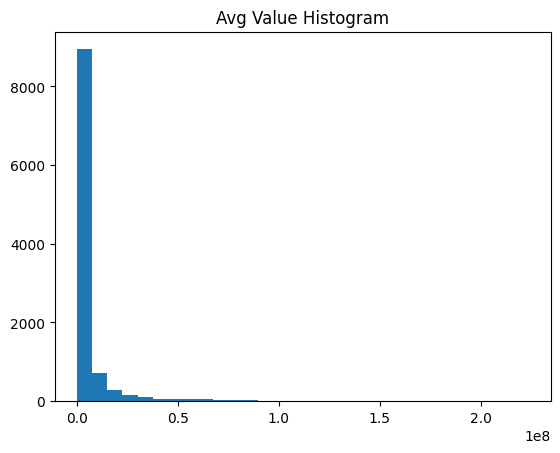

In [48]:
# Creating a histogram on the target variable.
import matplotlib.pyplot as plt

print(df["Avg Value"].describe())

plt.hist(df["Avg Value"], bins=30)
plt.title("Avg Value Histogram")
plt.show()

As you can see, the target variable is heavily right skewed. Therefore, I will apply a log transformation.

count    10554.000000
mean        14.403762
std          1.368437
min         12.206078
25%         13.399997
50%         14.096924
75%         15.297115
max         19.224922
Name: Log Avg Value, dtype: float64


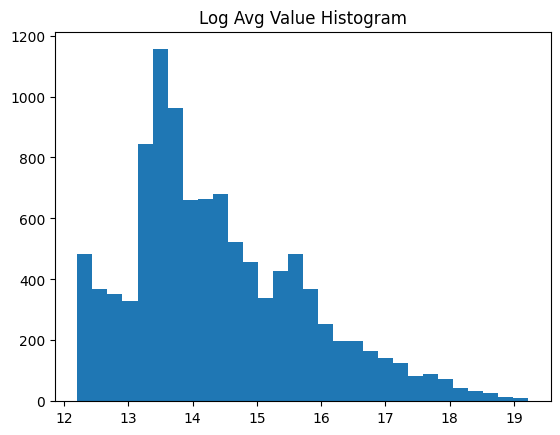

In [49]:
# Applying log transformtation on target variable
df["Log Avg Value"] = np.log1p(df["Avg Value"])
print(df["Log Avg Value"].describe())
plt.hist(df["Log Avg Value"], bins=30)
plt.title("Log Avg Value Histogram")
plt.show()

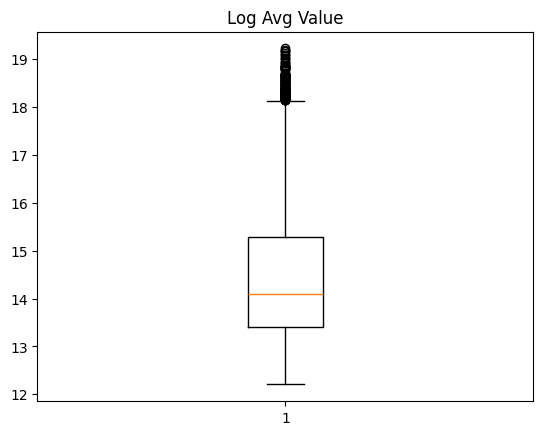

In [50]:
# Going to plot a boxplot to check for outliers after applying log transformation on y.

plt.boxplot(x=df["Log Avg Value"])
plt.title("Log Avg Value")
plt.show()

There appears to be a lot of outliers. I am going to remove these.

In [51]:
# Filtering out outliers that are the interquartile range above or below the third and first quartiles.
Q1 = df["Log Avg Value"].quantile(0.25)
Q3 = df["Log Avg Value"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - (1.5 * IQR)
upper_bound = Q3 + (1.5 * IQR)

df = df[(df["Log Avg Value"] >= lower_bound) & (df["Log Avg Value"] <= upper_bound)]

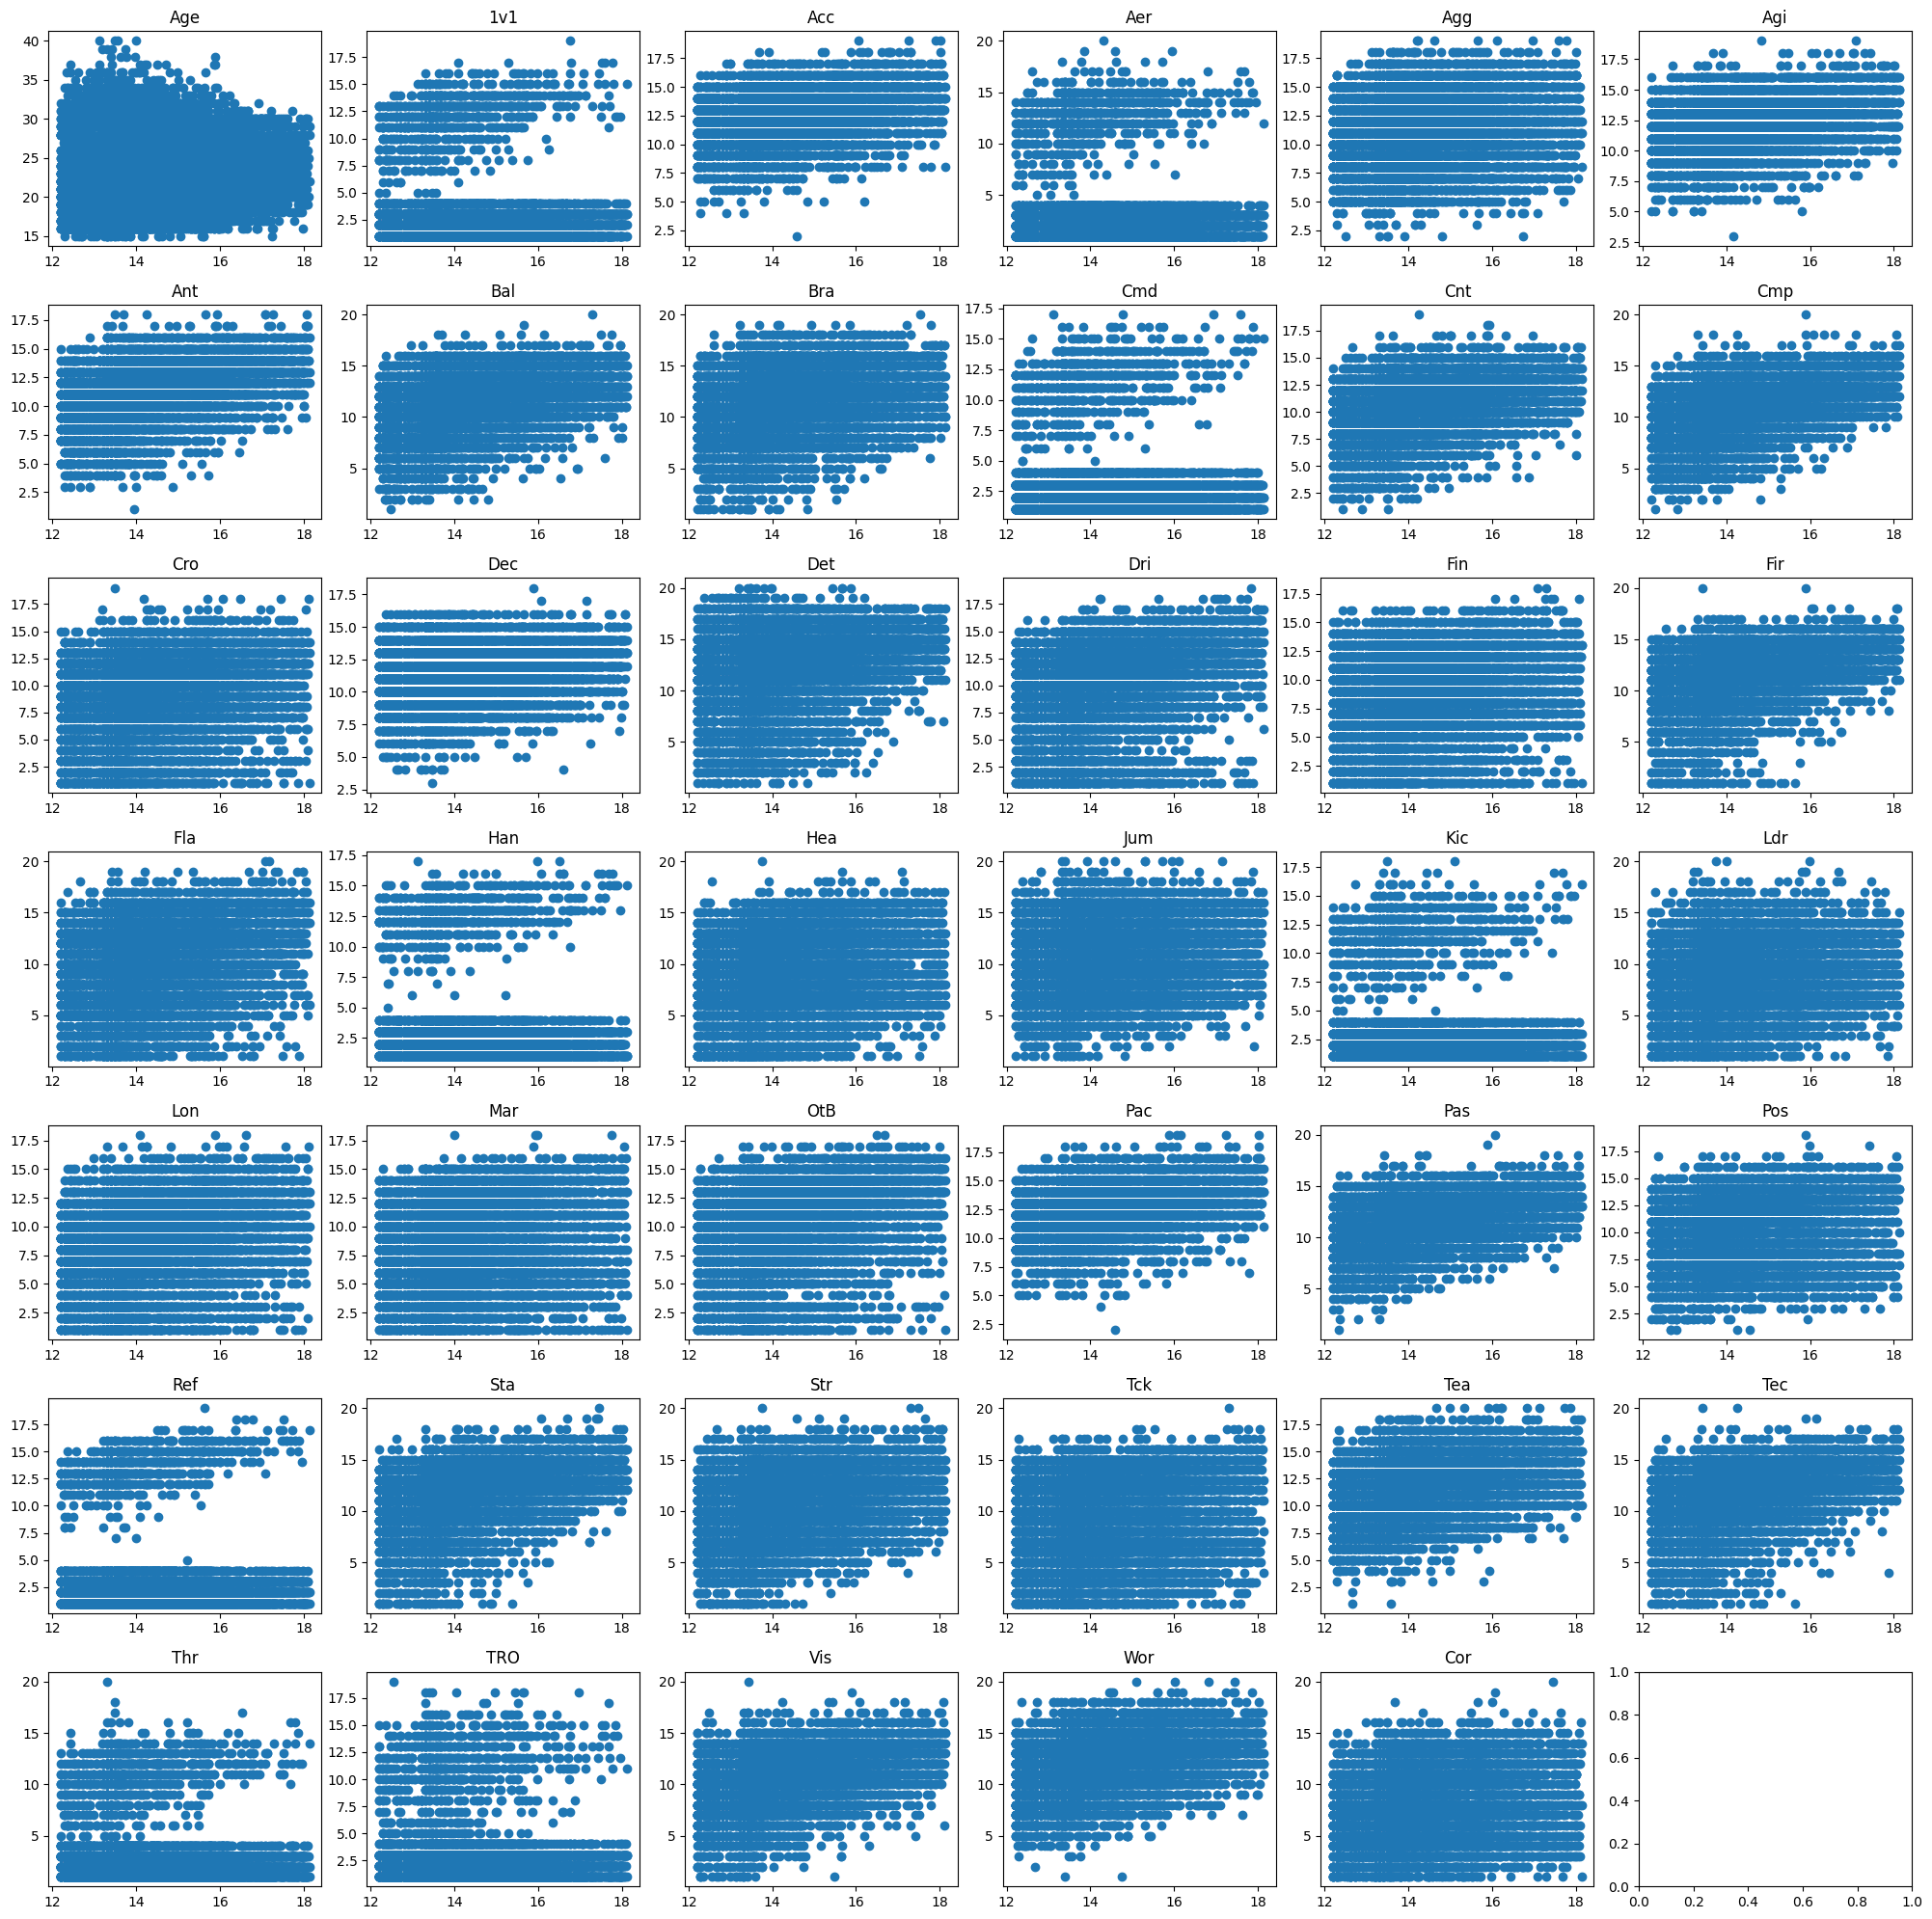

In [52]:
#Creating a grid of scatter plots, plotting the continuous features against y

n_rows, n_cols = 7, 6
columns = ["Age", "1v1", "Acc", "Aer", "Agg", "Agi", "Ant", "Bal", "Bra", "Cmd", "Cnt", "Cmp", "Cro",
               "Dec", "Det", "Dri", "Fin", "Fir", "Fla", "Han", "Hea", "Jum", "Kic", "Ldr", "Lon", "Mar",
               "OtB", "Pac", "Pas", "Pos", "Ref", "Sta", "Str", "Tck", "Tea", "Tec", "Thr", "TRO", "Vis",
               "Wor", "Cor"]
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20,20))
axes = axes.flatten()
for i, col in enumerate(columns):
    axes[i].scatter(df["Log Avg Value"], df[col])
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

As you can see from above, a clear insight to take from this is that the GK attributes are messing up everying else. The decision here should be to separate the model into a GK and an outfield model.

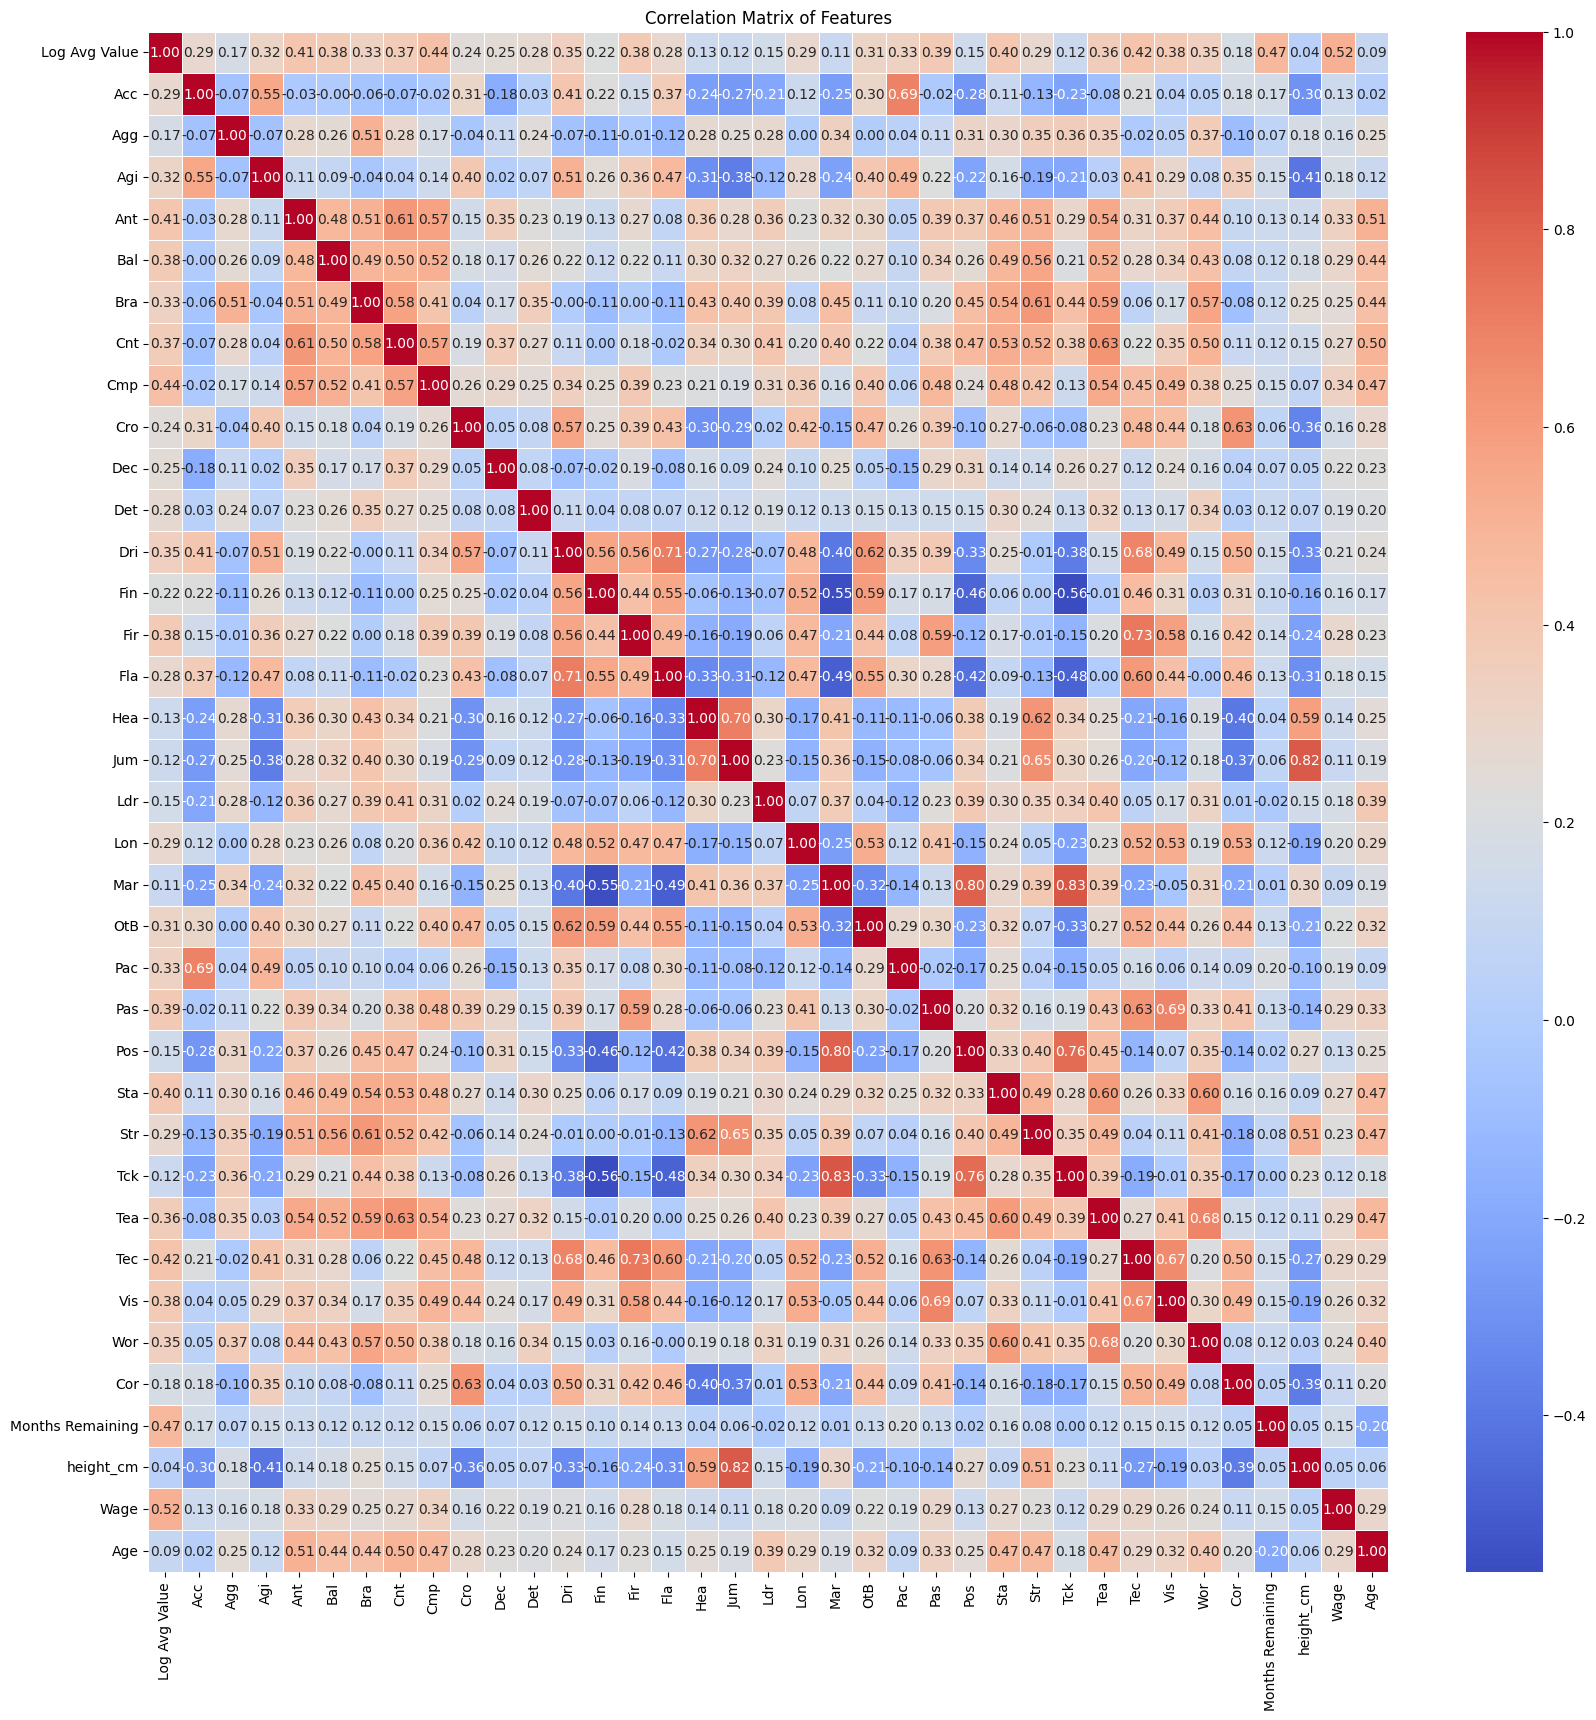

In [65]:
import seaborn as sns


# Creating a correlation matrix between all of the features
corr_matrix = df[["Log Avg Value", "Acc", "Agg", "Agi", "Ant", "Bal", "Bra",  "Cnt", "Cmp", "Cro",
               "Dec", "Det", "Dri", "Fin", "Fir", "Fla",  "Hea", "Jum", "Ldr", "Lon", "Mar",
               "OtB", "Pac", "Pas", "Pos", "Sta", "Str", "Tck", "Tea", "Tec",  "Vis",
               "Wor", "Cor", "Months Remaining", "height_cm", "Wage", "Age"]].corr()

plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix of Features")
plt.show()

I wouldn't say there are any big issues with the correlation matrix, however one insight is that some features could be merged, particularly the features that have a corr score of > 0.8.

### Feature Engineering

In [54]:
# Merging attributes into features that represent training groups.

df["Aerial ability"] = (df["height_cm"] + df["Jum"]).mean()
df["Defensive Ability"] = (df["Tck"] + df["Mar"]).mean()


Next I am going to build in some categorical variables, such as league and nationality. 

As to not have lots of features produced from one-hot enconding. I am going to create a feature called "Top 5 League" and it will be a binary 1 or 0 for whether the player plays in a top 5 league.

I am also going to do something similar with player nationality. Using this study https://football-observatory.com/IMG/sites/mr/mr55/en/ to make up the top 5.

In [55]:
# Binary variable to capture top 5 league effect.
top_5_leagues = ["English Premier Division", "Ligue 1 Uber Eats", "Spanish First Division", "Bundesliga", "Italian Serie A"]
df["Division"] = df["Division"].str.strip()
df["top_5_league"] = df["Division"].isin(top_5_leagues).astype(int)



# Binary variable to capture effect from coming from top footballing nation.
nationalities = ["ENG", "BRA", "FRA", "ESP", "ARG"]
df["Nat"] = df["Nat"].str.strip()
df["top_5_nations"] = df["Nat"].isin(nationalities).astype(int)




In [56]:
from sklearn.preprocessing import StandardScaler

# Scale the continuous variables
scaler = StandardScaler()
continuous_features = ["Acc", "Agg", "Agi", "Ant", "Bal", "Bra",  "Cnt", "Cmp", "Cro",
               "Dec", "Det", "Dri", "Fin", "Fir", "Fla",  "Hea", "Jum", "Ldr", "Lon", "Mar",
               "OtB", "Pac", "Pas", "Pos", "Sta", "Str", "Tck", "Tea", "Tec",  "Vis",
               "Wor", "Cor", "Months Remaining", "height_cm", "Wage", "Age", "Aerial ability", "Defensive Ability"]
df[continuous_features] = scaler.fit_transform(df[continuous_features])


# Currently I am filtering out GK players and GK attributes from the model.
df = df[~df["Position"].str.contains("GK")]

# Creating different feature sets
X_outfield = df[["Acc", "Agg", "Agi", "Ant", "Bal", "Bra",  "Cnt", "Cmp", "Cro",
               "Dec", "Det", "Dri", "Fin", "Fir", "Fla",  "Hea", "Jum", "Ldr", "Lon", "Mar",
               "OtB", "Pac", "Pas", "Pos", "Sta", "Str", "Tck", "Tea", "Tec",  "Vis",
               "Wor", "Cor", "Months Remaining", "height_cm", "Wage", "Age", "top_5_league", "top_5_nations"]]

X_outfield_dummies = df[["Acc", "Agg", "Agi", "Ant", "Bal", "Bra",  "Cnt", "Cmp", "Cro",
               "Dec", "Det", "Dri", "Fin", "Fir", "Fla",  "Hea", "Jum", "Ldr", "Lon", "Mar",
               "OtB", "Pac", "Pas", "Pos", "Sta", "Str", "Tck", "Tea", "Tec",  "Vis",
               "Wor", "Cor", "Months Remaining", "height_cm", "Wage", "Age", "Nat", "Division"]]

X_outfield_dummies = pd.get_dummies(X_outfield_dummies, columns=["Nat", "Division"], drop_first=True)

X_outfield_merged = df[["Acc", "Agg", "Agi", "Ant", "Bal", "Bra",  "Cnt", "Cmp", "Cro",
               "Dec", "Det", "Dri", "Fin", "Fir", "Fla",  "Hea", "Ldr", "Lon",
               "OtB", "Pac", "Pas", "Pos", "Sta", "Str", "Tea", "Tec",  "Vis",
               "Wor", "Cor", "Aerial ability", "Defensive Ability",  "Months Remaining", "Wage", "Age", "top_5_league", "top_5_nations"]]

y = df["Log Avg Value"]





### Model Building

In [57]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Testing the model for all attribute features
def train_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_train)
    mse = mean_squared_error(y_train, y_pred)
    r2 = r2_score(y_train, y_pred)
    return model, mse, r2, X_test, y_test

default_model, r2, mse, X_default_test, y_default_test = train_model(X_outfield, y)
print(f"Default feature set: r2: {r2} | mse: {mse}")

dummies_model, r2, mse, X_dummies_test, y_dummies_test = train_model(X_outfield_dummies, y)
print(f"Dummies feature set: r2: {r2} | mse: {mse}")

merged_model, r2, mse, X_merged_test, y_merged_test = train_model(X_outfield_merged, y)
print(f"Merged feature set: r2: {r2} | mse: {mse}")



Default feature set: r2: 0.5790891680346687 | mse: 0.6634970527572925
Dummies feature set: r2: 0.45057593530770346 | mse: 0.7381748121757225
Merged feature set: r2: 0.5833997803585274 | mse: 0.6609921988738705


The above shows that the merged set of features make the model peform the best. I find it odd that the dummies set performs worse than the other two.

I now plan to do some cross-validation testing on each model to test for bias/variance.

In [58]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer


def cross_validation(X, y):
    # Definining the scoring function
    mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

    # Definining the KFold split
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    model = LinearRegression()

    # Creating the Cross Validation scores
    cv_scores = cross_val_score(model, X, y, cv=kf, scoring=mse_scorer)
    cv_scores = -cv_scores
    mean_cv_score = np.mean(cv_scores)
    std_cv_score = np.std(cv_scores)

    return mean_cv_score

X_outfield_mse = cross_validation(X_outfield, y)
X_outfield_dummies_mse = cross_validation(X_outfield_dummies, y)
X_outfield_merged_mse = cross_validation(X_outfield_merged, y)

print(f"Default feature set MSE: {X_outfield_mse}")
print(f"Dummies feature set MSE: {X_outfield_dummies_mse}")
print(f"Merged feature set MSE: {X_outfield_merged_mse}")

Default feature set MSE: 0.5937469219606327
Dummies feature set MSE: 8.77599590074673e+19
Merged feature set MSE: 0.5978021863293368


As you can see from above, the cross validation testing shows that the default and merged feature set perform better, the dummy feature set shows high variance, and because the bias is also worse as shown from previous set. We are going to ignore this completely.

The Merged set shows slightly higher variance but a slighly lower bias, I am going to choose this feature set.

### Testing the Model

I am going to test the model using the testing set of data.

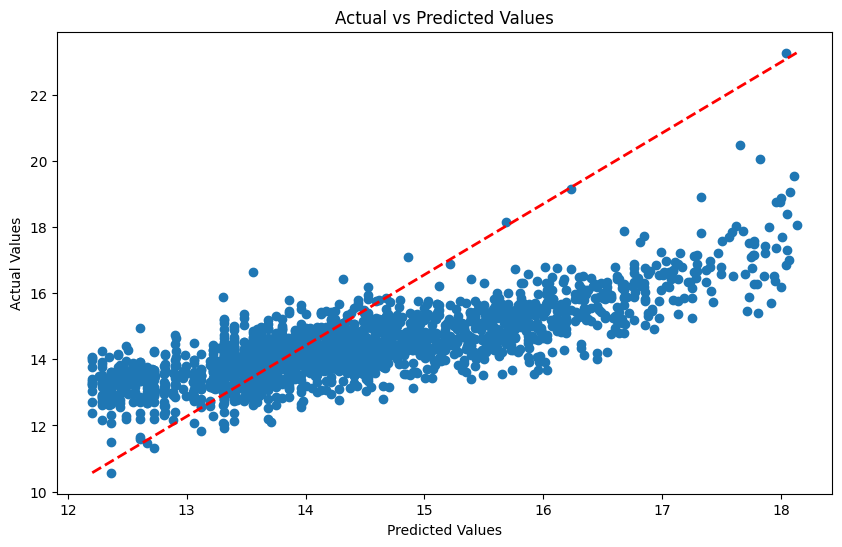

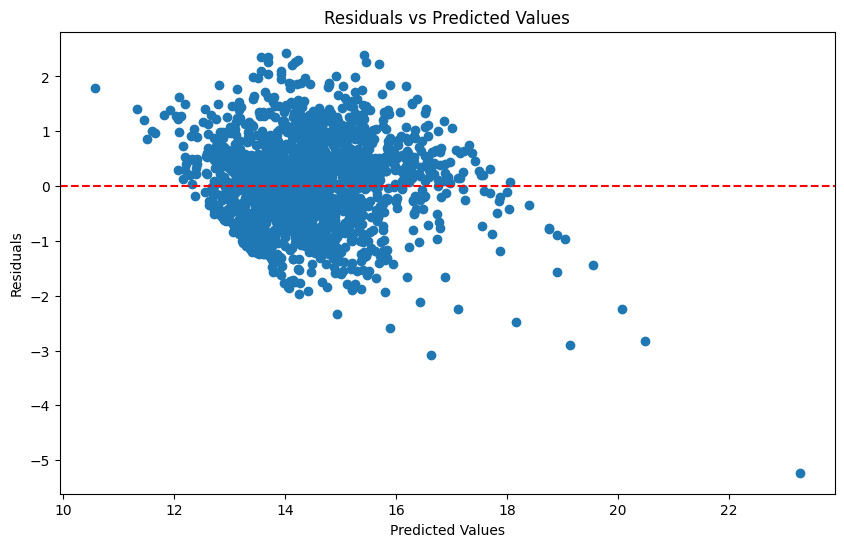

In [66]:
y_test_pred = merged_model.predict(X_merged_test)

residuals = y_merged_test - y_test_pred

plt.figure(figsize=(10,6))
plt.scatter(y_merged_test, y_test_pred)
plt.plot([y_merged_test.min(), y_merged_test.max()], [y_test_pred.min(), y_test_pred.max()], "r--", lw=2)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Actual vs Predicted Values')
plt.show()

plt.figure(figsize=(10,6))
plt.scatter(y_test_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.show()


The above shows that the model is showing a systematic bias towards values of higher actual value. It may show signs of heteroskedastcitity despite the applying of log transformation and removal of outliers on the target variable.

This suggests a more complex model than linear regression may be required here to achieve better results.

### Model Output Analysis

C:\Users\Owner\AppData\Local\Temp\ipykernel_15120\584901505.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("RdYlGn")


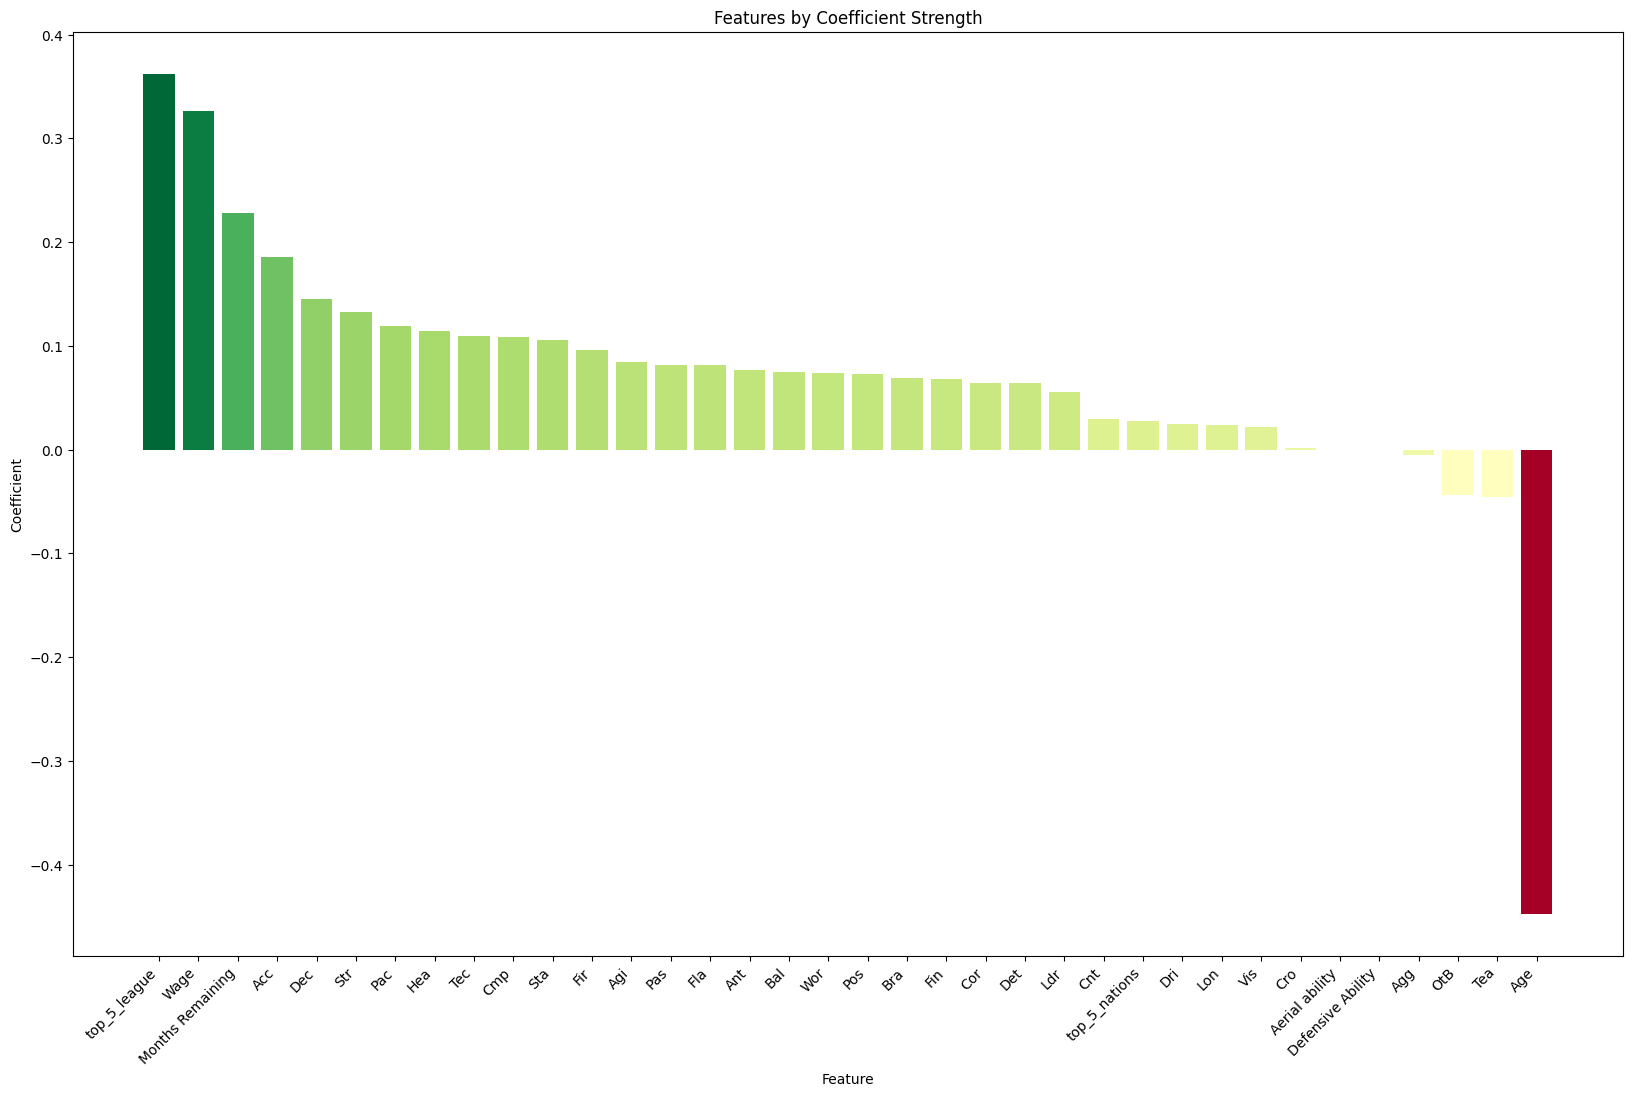

In [60]:
import matplotlib.cm as cm

coefficients = merged_model.coef_

# Sorting the data by feature coefficient valu
sorted_feature_data = sorted(zip(coefficients, X_outfield_merged.columns), reverse=True)
sorted_coefs, sorted_features = zip(*sorted_feature_data)

# Creating a colormap based on the normalised values of the coefficients
cmap = cm.get_cmap("RdYlGn")
norm = plt.Normalize(min(sorted_coefs), max(sorted_coefs))
colours = cmap(norm(sorted_coefs))

# Creating a bar chart to represent Feature importance
plt.figure(figsize=(20, 12))
plt.bar(sorted_features, sorted_coefs, color=colours)
plt.title("Features by Coefficient Strength")
plt.xlabel("Feature")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Coefficient")
plt.show()

The above graph demonstrates that Age has the strongest effect out of all features on price, with the older you are, the less valued you are on average. This aligns with common knowledge that younger players are worth more in the market.

The most important feature which increases transfer value on average is the top_5_league binary feature, this implies that being a player within a top 5 league means that you will be valued more on average than a player who is not. This makes intuitive sense, those leagues are the richest in the world and have the best teams, you can infer that not only will that mean that they have the best, and therefore most valuable, players but also their value may be inflated due to the fact they play for richer teams. A takeaway would be that on average, you would find better value in leagues outside of the top 5.

The next two most important features are wage and months remaining, these are both related to the context of the player's contracts. You would expect a higher wage to, on average, coincide with a higher value as more valuable players are paid more money and vice versa. Then, the amount of time remaining on a contract also makes sense as to why it would increase transfer value: when a contract is close to expiring, value plummets as you approach a window where you can sign a player on a fee transfer once the contract expires!

Now, looking at attributes, interestingly they do not have as strong importance relative to the other measures just discussed. The most important attributes measure is Acc which is Acceleration, Pace (Pac), follows shortly behind which suggests that a player's speed could be considered the most important attribute on average when valuing a player.

Off the Ball (OtB) and Teamwork (Tea) have negative affects on transfer value according to this model, perhaps surprsisingly. The teamwork effect could be maybe be explained by the notion that more talented players often show tendencies to be more individualistic and stereotypically "selfish", think Ronaldo. I can't think of any intuitive reasoning as to why Off the Ball would have a negative impact, perhaps more investigation into model performance is needed here.